In [115]:
import os
import numpy as np
from itertools import islice
import pandas as pd

path = './sims/output/'
extension = '.mco'
dirs = [e.name for e in os.scandir(path)]

wls = np.arange(740, 902, 2)
bin_size = 0.05
dists = np.arange(99)*bin_size
reflectance_lines = 99 # ignore the overflow bin
reflectance_col_header = "Rd_r #Rd[0], [1],..Rd[nr-1]. [1/cm2]\n"

def read_reflectance_data(folder):
    file_names = [folder + '_' + str(e) for e in range(len(wls))]

    result = np.zeros((len(wls), len(dists)))

    for i in range(len(wls)):
        with open(path + folder + '/' + file_names[i] + extension) as lines:
            read_file = lines.readlines()
            col_i = read_file.index(reflectance_col_header)
            result[i, :] = np.genfromtxt(read_file[col_i+1:col_i+reflectance_lines+1])
    
    return result

reflectances = {}
for dir in dirs:
    reflectances[dir] = read_reflectance_data(dir)

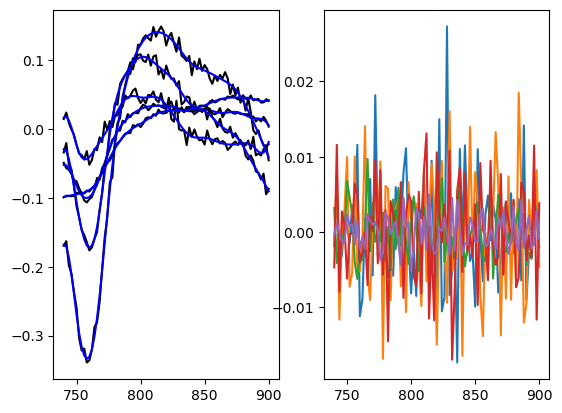

In [116]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline
from scipy.optimize import approx_fprime

degree = 3
n_knots = 14
central_knots = np.linspace(min(wls), max(wls), n_knots)
knots = np.r_[[min(wls)]*3, central_knots, [max(wls)]*3]

n_grads = 50
gradient_knots = np.linspace(min(wls), max(wls), 5)

def transform_data(y):
    y_prime = np.log(y)
    y_prime = y_prime - np.mean(y_prime)
    return y_prime

dist_i = 20
fig, axs = plt.subplots(nrows=1, ncols=2)
for key, e in islice(reflectances.items(), 5):
    y = transform_data(e[:, dist_i])
    spline = make_lsq_spline(wls, y, t=knots)
    
    axs[0].plot(wls, y, color='black')
    axs[0].plot(wls, spline(wls), color='blue')

    axs[1].plot(wls, y - spline(wls))

plt.show()

In [117]:
from sklearn.linear_model import LassoLarsIC

def generate_summary_statistics(distances, suffixes):
    summary_statistics = {k: {} for k in dirs}
    for key, e in reflectances.items():
        ys = [e[:, dist] for dist in distances]
        y_primes = [transform_data(y) for y in ys]

        splines = [make_lsq_spline(wls, y, t=knots) for y in ys]

        coeffs = np.array([y.c for y in splines])

        # spline coeffs for fits to y_prime
        for suffix, coeff in zip(suffixes, coeffs):
            summary_statistics[key]['spline_' + suffix] = coeff
        
        # gradients of spline fits at central_knots
        for suffix, y in zip(suffixes, splines):
            summary_statistics[key]['spline_gradient_' + suffix] = np.diag(approx_fprime(gradient_knots, y))
        
        # differences in log(mean) of y
        log_means = [np.log(np.mean(y)) for y in ys]
        summary_statistics[key]['log_mean'] = np.diff(log_means)
        
        for suffix, y in zip(suffixes, ys):
            summary_statistics[key]['mean_' + suffix] = np.mean(y)
            summary_statistics[key]['variance_' + suffix] = np.var(np.log(y))
            summary_statistics[key]['minimax_' + suffix] = np.array([np.max(y), np.min(y)])
            summary_statistics[key]['minimaxwl_' + suffix] = np.array([wls[np.argmax(y)], wls[np.argmin(y)]])
    
    return summary_statistics

def run_whole_thing(distances, df, target_col, extra_powers=[2]):
    suffixes = [str(e) for e in range(len(distances))]
    summary_statistics = generate_summary_statistics(distances, suffixes)

    def build_summary_stat_x(uuid):
        summary = summary_statistics[uuid]
        summary_stats = [np.atleast_1d(summary[key + '_' + suffix]) for key in ['variance', 'spline'] for suffix in suffixes] + [summary[key] for key in ['log_mean']]
        base_stats = np.concatenate(summary_stats)
        return np.concatenate([base_stats] + [np.power(base_stats, e) for e in extra_powers])
    
    for key in ['one', 'two']:
        df[f'oxy_blood_{key}'] = df[f'blood_{key}']*df[f'blood_sat_{key}']
        df[f'deoxy_blood_{key}'] = df[f'blood_{key}']*(1 - df[f'blood_sat_{key}'])
    df = df[[target_col, 'uuid']]

    df = df[df.loc[:, 'uuid'].apply(lambda uuid: uuid in reflectances)]
    df.loc[:, 'x'] = df.loc[:, 'uuid'].apply(build_summary_stat_x)

    y = np.zeros(len(df))
    mat = np.zeros((len(df), len(df['x'].iloc[0])))

    print('mat shape:', mat.shape)

    for i, (_, row) in enumerate(df.iterrows()):
        y[i] = row[target_col]
        mat[i, :] = row['x']

    model = LassoLarsIC(normalize=True).fit(mat, y)

    print("fit model with alpha_:", model.alpha_)
    print("AIC = ", np.min(model.criterion_))
    
    # matrix eqn y = mat @ beta

    #beta = np.linalg.pinv(mat) @ y
    beta = model.coef_

    # model y as mat @ beta

    summary_stat = mat @ beta

    df.loc[:, 'summary_stat'] = df.loc[:, 'x'].apply(lambda x: np.sum(x * beta))

    return y, summary_stat, df, model

def fit_gp(x, y):
    pass

mat shape: (207, 106)
fit model with alpha_: 3.848360381071516e-06
AIC =  -70.47409249379822


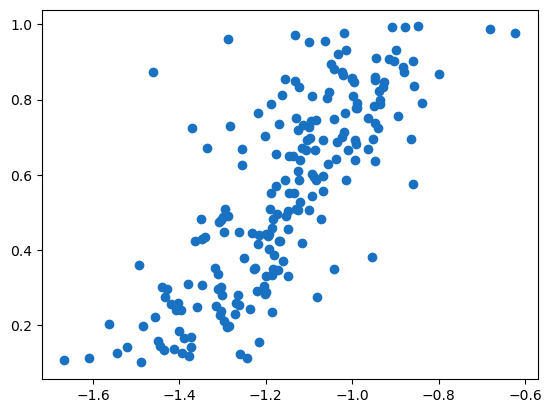

In [118]:
from constants.colors import colors

df = pd.read_csv('./sims/df.csv', index_col=0)

target = 'height_csf'
y, summary_stat, df_, _ = run_whole_thing([40, 45, 50], df, target)

plt.figure()
plt.scatter(df_['summary_stat'], df_[target], color=colors['blue'][8])
plt.show()

In [129]:
point_style_kwargs = {
    "color": colors['blue'][8],
    "alpha": 0.8,
    "edgecolors": 'black'
}

def add_top_left_text(label, ax):
    ax.text(0.025, 0.975, label, verticalalignment='top', fontsize=14, transform=ax.transAxes)

def add_bottom_right_text(label, ax):
    ax.text(0.975, 0.025, label, verticalalignment='bottom', horizontalalignment='right', fontsize=12, transform=ax.transAxes)

def fit_text(model):
    aic_string = f'AIC = {str(np.round(np.min(model.criterion_), 1))} '
    alpha_string = r'$\alpha$ = ' + '{:0.2e}'.format(model.alpha_)
    combined_string = '\n'.join([aic_string, alpha_string])

    return aic_string, alpha_string, combined_string

Creating a figure for CSF inference

mat shape: (207, 105)
fit model with alpha_: 1.1652777328897135e-05
AIC =  -11.715474340799432
AIC = -11.7 
$\alpha$ = 1.17e-05
mat shape: (207, 159)
fit model with alpha_: 7.951683000388347e-07
AIC =  -94.33809411635553
AIC = -94.3 
$\alpha$ = 7.95e-07


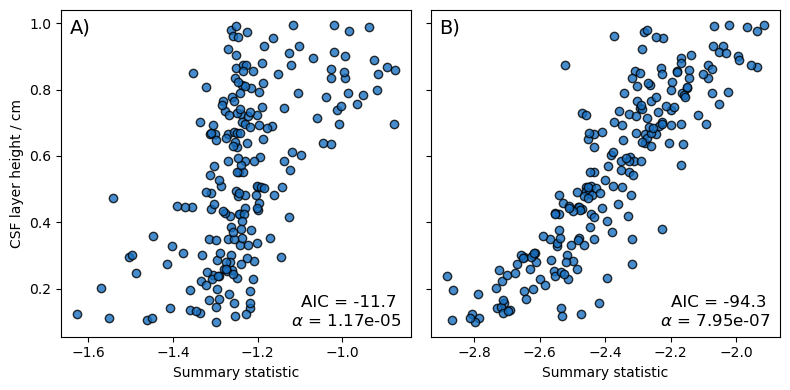

In [130]:
distances = [
    [40, 50],
    [40, 45, 50]
]

powers = [
    [2, 3],
    [2, 3]
]

labels = ['A)', 'B)']

target = 'height_csf'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey='all')

for dist, power, ax, label in zip(distances, powers, axs, labels):
    _, _, df_, model = run_whole_thing(dist, df, target, extra_powers=power)
    x, y = df_['summary_stat'], df_[target]
    ax.scatter(x, y, **point_style_kwargs)
    ax.set_xlabel('Summary statistic')
    add_top_left_text(label, ax)
    _, _, combined_string =  fit_text(model)
    add_bottom_right_text(combined_string, ax)

axs[0].set_ylabel('CSF layer height / cm')
plt.tight_layout()
plt.savefig('./figure_generation/figures/csf_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/csf_inference.pdf', dpi=600, transparent=True)
plt.show()

Apparent inference for skin skull layer

mat shape: (207, 140)
fit model with alpha_: 6.440067717658193e-05
AIC =  1464.9371638057373
mat shape: (207, 140)
fit model with alpha_: 3.789527299595096e-06
AIC =  910.5754352014225


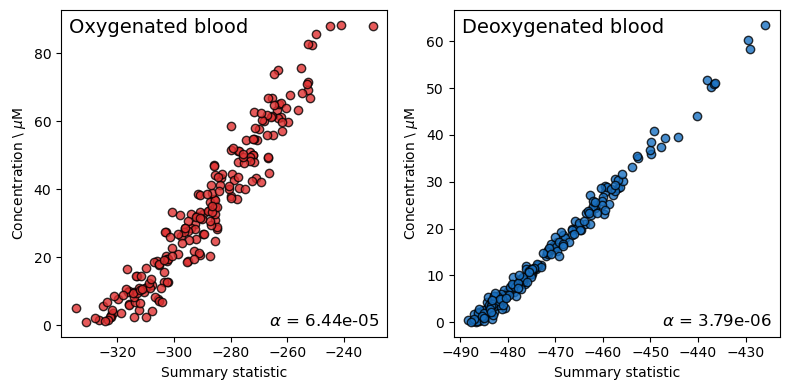

In [143]:
distances = [10, 15]
powers = [2, 3, 4]

labels = ['Oxygenated blood', 'Deoxygenated blood']
targets = ['oxy_blood_one', 'deoxy_blood_one']
scatter_colors = [colors['red'][8], colors['blue'][8]]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for ax, label, target, color in zip(axs, labels, targets, scatter_colors):
    _, _, df_, model = run_whole_thing(distances, df, target, extra_powers=powers)
    x, y = df_['summary_stat'], df_[target]
    kwargs = point_style_kwargs.copy()
    kwargs['color'] = color
    ax.scatter(x, y, **kwargs)
    ax.set_xlabel('Summary statistic')
    ax.set_ylabel(r'Concentration \ $\mu$M')
    add_top_left_text(label, ax)
    _, alpha_string, _ = fit_text(model)
    add_bottom_right_text(alpha_string, ax)

plt.tight_layout()
plt.savefig('./figure_generation/figures/first_layer_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/first_layer_inference.pdf', dpi=600, transparent=True)
plt.show()

Inference for 2nd layer oxygenated and deoxygenated blood with variable CSF

mat shape: (207, 105)
fit model with alpha_: 0.023398731677127374
AIC =  1859.2275299804585
mat shape: (207, 159)
fit model with alpha_: 0.02257740948392784
AIC =  1862.2378225961904
mat shape: (207, 105)
fit model with alpha_: 0.00032742293465071106
AIC =  1589.1323928458003
mat shape: (207, 159)
fit model with alpha_: 4.8222565163657146e-05
AIC =  1584.564793605152


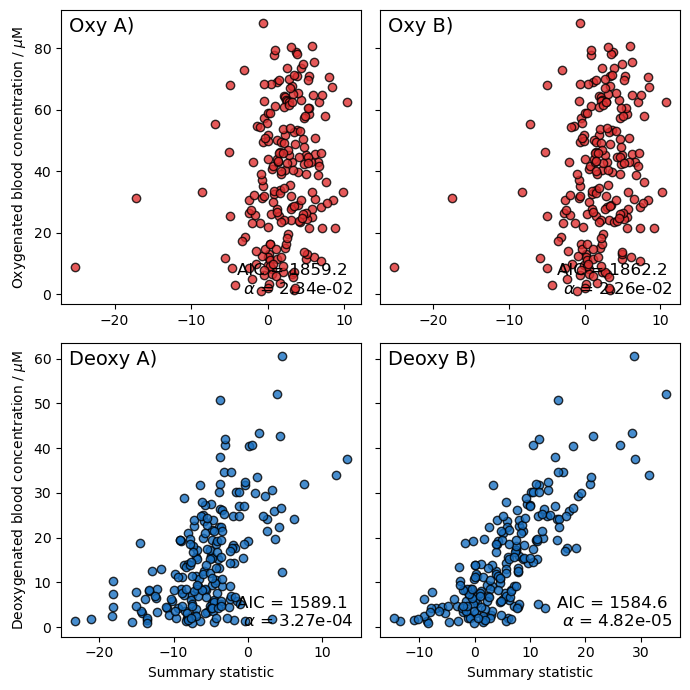

In [145]:
distances = [
    [40, 50],
    [40, 45, 50],
]

powers = [
    [2, 3],
    [2, 3],
]

labels = [['Oxy A)', 'Oxy B)'], ['Deoxy A)', 'Deoxy B)']]
scatter_colors = [colors['red'][8], colors['blue'][8]]
targets = ['oxy_blood_two', 'deoxy_blood_two']
y_labels = [r'Oxygenated blood concentration / $\mu$M', r'Deoxygenated blood concentration / $\mu$M']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), sharey='row')

for i, ax_row in enumerate(axs):
    ax_row[0].set_ylabel(y_labels[i])
    for j, ax in enumerate(ax_row):
        _, _, df_, model = run_whole_thing(distances[j], df, targets[i], extra_powers=powers[i])
        x, y = df_['summary_stat'], df_[targets[i]]
        kwargs = point_style_kwargs.copy()
        kwargs['color'] = scatter_colors[i]
        ax.scatter(x, y, **kwargs)
        add_top_left_text(labels[i][j], ax)
        _, _, combined_string =  fit_text(model)
        add_bottom_right_text(combined_string, ax)
        if i == 1:
            ax.set_xlabel('Summary statistic')


plt.tight_layout()
plt.show()